On utilise igraph : Permet de gérer des graphes, avec des fonctionnalités pour ajouter ou supprimer des nœuds et des arêtes, traiter des matrices d'adjacence, tracer des graphes, etc.

In [2]:
# Install the igraph python library - see also: https://igraph.org/python/tutorial/latest/tutorial.html
# This is a library that allows internal handling of the graph with functionalities supporting nodes, edges additions/removals,
# adjacency matrix processing, plotting layouts and so on. Another even more known library is networkx: https://networkx.org/,
# with similar functionality and also possibilites of direct conversion from its graph format to PyTorch format for further
# GNN processing (although this is not always error-free).

!pip install python-igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 16.4 MB/s eta 0:00:00


l'article original de la méthode GNN-LRP (Graph Neural Network Layer-wise Relevance Propagation) est disponible à cette adresse : https://arxiv.org/abs/2006.03589

In [3]:
import igraph
import numpy as np


def relevance_curves_xy_computation(nodes_x_coors_list: list, nodes_y_coors_list: list):
    """
    calcule les coordonnées x et y des points représentant des courbes de pertinence dans un graphique.
    Ces courbes montrent la pertinence d'une marche (composée de 3 nœuds et de 2 arêtes les reliant) par la couleur des courbes.
     Les courbes sont dessinées de manière à éviter tout chevauchement, afin de représenter clairement la pertinence de chaque marche dans le graphe.

    :param nodes_x_coors_array: Liste des coordonnées x des trois nœuds de la marche.
    :param nodes_y_coors_array: Liste des coordonnées y des trois nœuds de la marche.
    :return: Les nouvelles coordonnées x et y des courbes de pertinence après ajustement.
    """

    relevance_line_curve_x_coors_list = np.array(nodes_x_coors_list)
    relevance_line_curve_y_coors_list = np.array(nodes_y_coors_list)

    if relevance_line_curve_x_coors_list[0] == relevance_line_curve_x_coors_list[1] == relevance_line_curve_x_coors_list[2] and \
            relevance_line_curve_y_coors_list[0] == relevance_line_curve_y_coors_list[1] == relevance_line_curve_y_coors_list[2]:
        relevance_line_curve_x_coors_list = relevance_line_curve_x_coors_list[0] + 0.1 * np.cos(np.linspace(0, 2 * np.pi, 50))
        relevance_line_curve_y_coors_list = relevance_line_curve_y_coors_list[0] + 0.1 * np.sin(np.linspace(0, 2 * np.pi, 50))
    else:
        relevance_line_curve_x_coors_list = 0.75 * relevance_line_curve_x_coors_list + 0.25 * relevance_line_curve_x_coors_list.mean()
        relevance_line_curve_y_coors_list = 0.75 * relevance_line_curve_y_coors_list + 0.25 * relevance_line_curve_y_coors_list.mean()

        relevance_line_curve_x_coors_list = np.concatenate([
            np.linspace(relevance_line_curve_x_coors_list[0], relevance_line_curve_x_coors_list[0], 41),
            np.linspace(relevance_line_curve_x_coors_list[0], relevance_line_curve_x_coors_list[1], 20),
            np.linspace(relevance_line_curve_x_coors_list[1], relevance_line_curve_x_coors_list[2], 20),
            np.linspace(relevance_line_curve_x_coors_list[2], relevance_line_curve_x_coors_list[2], 41), ])
        relevance_line_curve_y_coors_list = np.concatenate([
            np.linspace(relevance_line_curve_y_coors_list[0], relevance_line_curve_y_coors_list[0], 41),
            np.linspace(relevance_line_curve_y_coors_list[0], relevance_line_curve_y_coors_list[1], 20),
            np.linspace(relevance_line_curve_y_coors_list[1], relevance_line_curve_y_coors_list[2], 20),
            np.linspace(relevance_line_curve_y_coors_list[2], relevance_line_curve_y_coors_list[2], 41)])

        filt = np.exp(-np.linspace(-2, 2, 41) ** 2)
        filt = filt / filt.sum()

        relevance_line_curve_x_coors_list = np.convolve(relevance_line_curve_x_coors_list, filt, mode='valid')
        relevance_line_curve_y_coors_list = np.convolve(relevance_line_curve_y_coors_list, filt, mode='valid')


    return relevance_line_curve_x_coors_list, relevance_line_curve_y_coors_list

def compute_walks(adj_matrix: np.ndarray):
    """
    Calcule toutes les marches de longueur 3 dans un graphe, où une marche est une séquence de trois nœuds connectés par des arêtes.

    :param adj_matrix: La matrice d'adjacence du graphe.
    :return: Une liste de tuples représentant les marches (chaque tuple contient trois indices de nœuds qui forment une marche de longueur 3).
    """

    w = []

    for v1 in np.arange(len(adj_matrix)):
        for v2 in np.where(adj_matrix[v1])[0]:
            for v3 in np.where(adj_matrix[v2])[0]:

                w += [(v1, v2, v3)]

    return w


def set_graph_layout(adj_matrix: np.ndarray, seed):
    """
    Crée un graphe à partir de la matrice d'adjacence et définit son agencement à l'aide de l'algorithme Kamada-Kawai.
    Ce dernier est une méthode pour positionner les nœuds du graphe de manière à minimiser l'énergie dans une configuration de ressorts.

    :param adj_matrix: La matrice d'adjacence du graphe.
    :param seed: La graine aléatoire pour garantir la reproductibilité de l'agencement.
    :return: Un tableau numpy contenant les positions des nœuds dans le plan, après application de l'agencement Kamada-Kawai.
    """

    graph = igraph.Graph()
    graph.add_vertices(len(adj_matrix))
    graph.add_edges(zip(*np.where(adj_matrix == 1)))

    return np.array(list(graph.layout_kamada_kawai()))

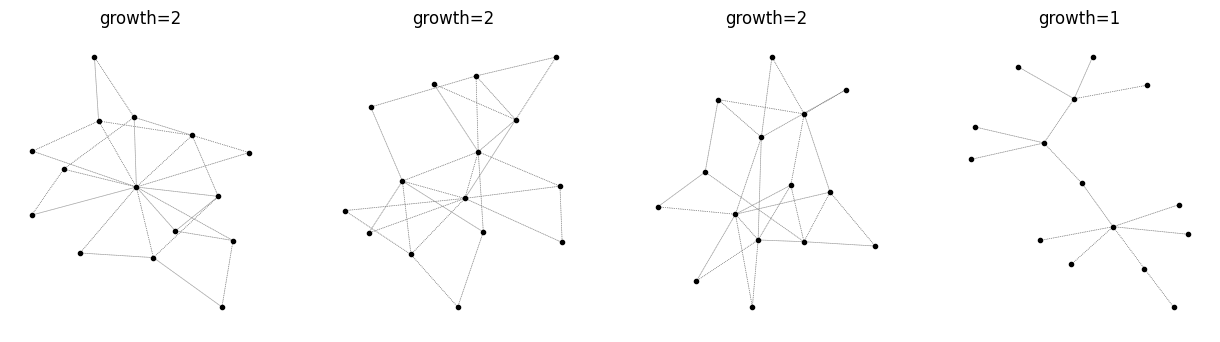

Training model:
   iter | loss
   -----------
       0 0.500
    1000 0.480
    2000 0.324
    3000 0.149
    4000 0.074
    5000 0.042
    6000 0.029
    7000 0.021
    8000 0.015
    9000 0.013
   10000 0.011
   11000 0.009
   12000 0.008
   13000 0.007
   14000 0.006
   15000 0.005
   16000 0.005
   17000 0.004
   18000 0.005
   19000 0.004
   20000 0.004
For 200 test sample graphs, the model predicts the growth parameter with an accuracy of 100.0 %


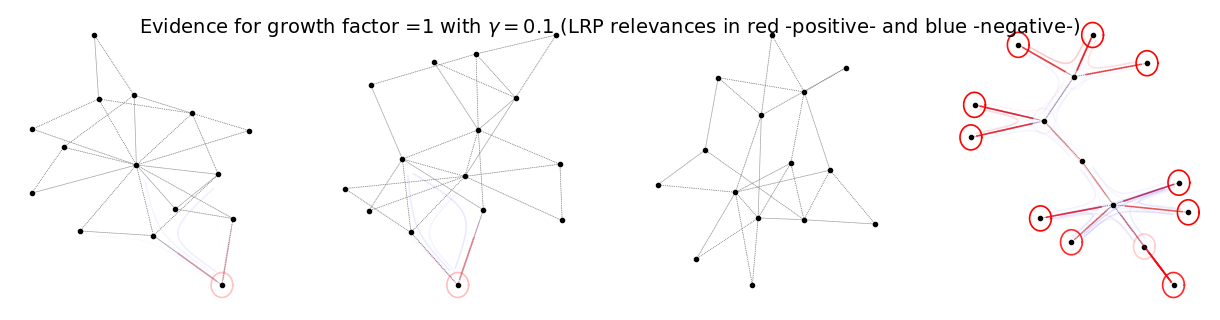

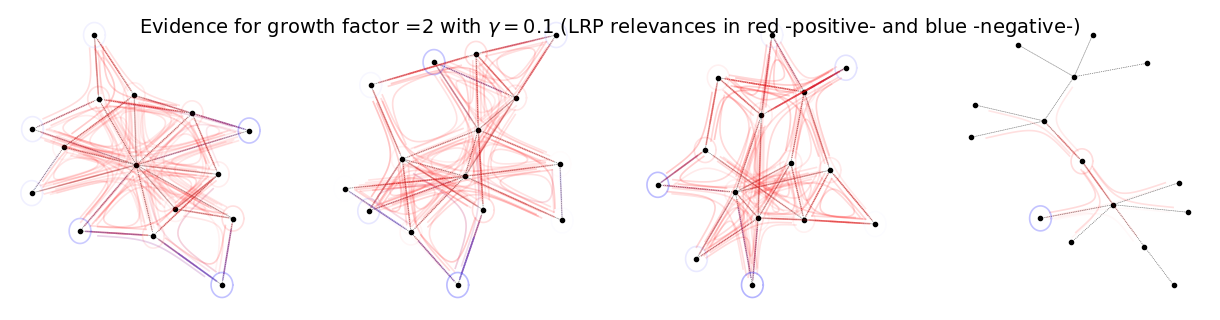

In [5]:
import random
import sys

import igraph
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch


########################################################################################################################
# [A.] Create example graphs and plots thereof =========================================================================
########################################################################################################################
def create_scale_free_graph(nodes_nr: int, input_seed: int = 0, embed: bool = False, growth=None):
    """
    implémente le modèle de Barabási-Albert pour créer un graphe scale-free (sans échelle),
    c'est-à-dire un graphe dont la distribution des degrés suit une loi de puissance à grande échelle.
    Les graphes de ce type sont souvent utilisés pour modéliser des réseaux complexes, comme ceux présents dans les réseaux sociaux ou le web.

    :param nodes_nr: Le nombre de nœuds (ou sommets) du graphe.
    :input_seed: La graine pour la génération aléatoire, garantissant des résultats reproductibles.
    :embed: Un paramètre qui, s'il est activé, permet de générer une disposition visuelle du graphe.
    :growth: Le paramètre de croissance du modèle de Barabási-Albert. À chaque étape, un nouveau nœud est ajouté,
    et il se connecte à un certain nombre de nœuds déjà existants dans le graphe. Si ce paramètre n'est pas spécifié, un nombre aléatoire entre 1 et 3 est choisi.

    :return:
    """

        # [1.] Définir le nombre de nœuds et la matrice d'adjacence -------------------------------------------------------------
    adj_matrix = np.zeros([nodes_nr, nodes_nr])     # Matrice d'adjacence
    adj_matrix[1, 0] = 1
    adj_matrix[0, 1] = 1

    # Le graphe généré qui se développe au fil du temps. À chaque étape, un nouveau nœud avec un nombre de liens "growth" -----
    # connectant le nouveau nœud à un nombre "growth" de nœuds déjà présents dans le réseau est ajouté ---------------------
    random = np.random.mtrand.RandomState(input_seed)
    growth = growth if growth is not None else random.randint(1, 3)
    N0 = 2

    # [2.] Créer les arêtes selon le paramètre de croissance --------------------------------------------------------------
    #      Le nombre de nœuds du graphe est spécifié ici. Ce qui n'est pas spécifié, ce sont les arêtes.
    #      L'implémentation du code définit le processus de création du graphe *scale-free* à partir de zéro.
    #      En supposant que nous sommes à une étape de ce processus et que nous avons déjà un graphe,
    #      on peut penser à augmenter ce graphe en insérant un nouveau nœud, qui sera connecté à
    #      d'autres nœuds déjà présents dans le graphe. La décision de quel nœud sera "relié" au nouveau
    #      est déterminée par le facteur de croissance. Ce facteur définit la probabilité que le nouveau nœud
    #      se connecte aux nœuds déjà présents dans le graphe.
    for i in range(N0, nodes_nr):
        if growth == 1 : tt = 1     # Barabasi-Albert avec croissance 1
        elif growth == 2 : tt = 2   # Barabasi-Albert avec croissance 2
        else:
            tt = 1 + 1*((growth-1) > random.uniform(0, 1))

        p = adj_matrix.sum(axis=0)/adj_matrix.sum()

        for j in random.choice(nodes_nr, tt, p=p, replace=False):
            adj_matrix[i, j] = 1
            adj_matrix[j, i] = 1

    r = random.permutation(len(adj_matrix))
    adj_matrix = adj_matrix[r][:, r]*1.0

    # [3.] Ajouter des auto-connexions dans la matrice d'adjacence --------------------------------------------------------
    adj_matrix = adj_matrix + np.identity(len(adj_matrix))

    # [4.] Calculer le Laplacien du graphe ------------------------------------------------------------------------------
    D = adj_matrix.sum(axis=1)
    laplacian_matrix = torch.FloatTensor(adj_matrix/(np.outer(D, D)**.5+1e-9))

    # [5.] Calculer la structure de données d'information du graphe (dictionnaire) -------------------------------------
    #      Le dataset est composé de paires (graphe_de_facteur_de_croissance, facteur_de_croissance)
    #      le second élément étant la cible, comme on le voit dans la structure de données retournée
    return {
        'adjacency': torch.FloatTensor(adj_matrix),
        'laplacian': laplacian_matrix,
        'target': growth,
        'layout': set_graph_layout(adj_matrix, input_seed) if embed else None,
        'walks': compute_walks(adj_matrix)
    }



def visualize_graph(graph_data_structure: dict, ax):
    """
    Fonction pour visualiser un graphe

    :param graph_data_structure: Structure de données du graphe (dictionnaire)
    :param ax: Axe du graphique
    :return:
    """

    # [1.] Organiser la disposition du graphe pour l'affichage -------------------------------------------------------
    r = graph_data_structure['layout']
    r = r - r.min(axis=0)
    r = r / r.max(axis=0) * 2 - 1

    # [2.] Afficher les arêtes ----------------------------------------------------------------------------------------
    nodes_nr = len(graph_data_structure['adjacency'])
    for i in np.arange(nodes_nr):
        for j in np.arange(nodes_nr):
            if graph_data_structure['adjacency'][i, j] > 0 and i != j:
                plt.plot([r[i, 0], r[j, 0]], [r[i, 1], r[j, 1]],
                         color='gray',
                         lw=0.5,
                         ls='dotted')

    # [3.] Afficher les nœuds ----------------------------------------------------------------------------------------
    ax.plot(r[:, 0], r[:, 1], 'o', color='black', ms=3)



# Tracer quelques graphes d'exemple ---------------------------------------------------------------------------------
sample_ids = [7, 10, 12, 15]  # Nouveaux identifiants des exemples à afficher
nodes_nr = 15  # Nombre de nœuds pour chaque graphe, augmenté pour tester des graphes plus complexes

plt.figure(figsize=(3 * len(sample_ids), 3))  # Créer une figure avec une taille adaptée au nombre d'exemples
for ids, seed in enumerate(sample_ids):

    ax = plt.subplot(1, len(sample_ids), ids + 1)  # Créer un sous-graphe pour chaque exemple
    example_graph = create_scale_free_graph(nodes_nr, input_seed=seed, embed=True)  # Générer un graphe d'exemple avec le paramètre 'seed'

    visualize_graph(example_graph, ax=ax)  # Visualiser le graphe sur le sous-graphe
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)  # Ajuster l'affichage des sous-graphes pour qu'ils prennent toute la place

    plt.axis('off')  # Masquer les axes pour ne pas perturber l'affichage du graphe
    plt.xlim(-1.2, 1.2)  # Définir les limites de l'axe des x
    plt.ylim(-1.2, 1.2)  # Définir les limites de l'axe des y
    ax.set_title(f"growth={example_graph['target']}")  # Afficher la valeur du paramètre 'growth' dans le titre du sous-graphe

plt.show()  # Afficher la figure contenant tous les sous-graphes
plt.close()  # Fermer la figure pour libérer la mémoire



########################################################################################################################
# [B.] Créer GraphNet GNN ::: Définir l'architecture, les méthodes forward et lrp ====================================
########################################################################################################################
class GraphNet:
    """
    Graph Net - Le réseau de neurones graphiques (GNN)

    La matrice d'adjacence seule n'est généralement pas suffisante. Les nœuds du graphe ont des caractéristiques
    (comme la taille, la couleur, etc.) et les arêtes ont également des caractéristiques correspondantes (distance, poids, ...).
    Ainsi, seulement dans ce cas particulier, ce graphe très simple où, en principe, seule la connectivité est utilisée pour
    la classification, la matrice d'adjacence suffit.

    """

    def __init__(self, input_layer_size: int, hidden_layer_size: int, output_layer_size: int):
        """
        Initialisation de l'architecture du GNN

        :param input_layer_size: Taille de la couche d'entrée
        :param hidden_layer_size: Taille de la couche cachée
        :param output_layer_size: Taille de la couche de sortie
        """

        # [1.] Architecture du GNN --------------------------------------------------------------------------------------
        #      Poids/paramètres du GNN --------------------------------------------------------------------------------
        #      U les poids/paramètres de la couche d'entrée, V les poids/paramètres de la dernière couche -------------
        self.U = torch.nn.Parameter(torch.FloatTensor(np.random.normal(0, input_layer_size ** -.5,
                                                                       [input_layer_size, hidden_layer_size])))
        self.W1 = torch.nn.Parameter(torch.FloatTensor(np.random.normal(0, hidden_layer_size ** -.5,
                                                                        [hidden_layer_size, hidden_layer_size])))
        self.W2 = torch.nn.Parameter(torch.FloatTensor(np.random.normal(0, hidden_layer_size ** -.5,
                                                                        [hidden_layer_size, hidden_layer_size])))
        self.V = torch.nn.Parameter(torch.FloatTensor(np.random.normal(0, hidden_layer_size ** -.5,
                                                                       [hidden_layer_size, output_layer_size])))

        # [2.] Poids/paramètres du GNN --------------------------------------------------------------------------------
        self.params = [self.U, self.W1, self.W2, self.V]

    def forward_pass(self, adj_matrix: torch.Tensor):
        """
        Passage avant du GNN

        :param adj_matrix: Matrice d'adjacence du GNN
        :return: Sortie du GNN
        """

        H = torch.eye(len(adj_matrix))  # Matrice identité pour initialiser H
        H = H.matmul(self.U).clamp(min=0)  # Application de U sur H avec activation ReLU
        H = (adj_matrix.transpose(1, 0).matmul(H.matmul(self.W1))).clamp(min=0)  # Propagation via W1
        H = (adj_matrix.transpose(1, 0).matmul(H.matmul(self.W2))).clamp(min=0)  # Propagation via W2
        H = H.matmul(self.V).clamp(min=0)  # Dernière propagation via V

        return H.mean(dim=0)  # Moyenne sur la dimension 0 pour obtenir la sortie


    def lrp_computation(self, adj_matrix: torch.Tensor, gamma: float, target: int, indexes: tuple):
        """
        Calcul de la pertinence LRP, tel que présenté dans l'article original : https://arxiv.org/abs/2006.03589

        :param adj_matrix: Matrice d'adjacence du graphe
        :param gamma: Hyperparamètre gamma pour LRP
        :param target: Classe cible pour laquelle nous calculons la pertinence
        :param indexes: Indices des nœuds dans le graphe
        """

        # [1.] Créer un tableau colonne contenant un seul élément non nul ------------------------------
        #      à la position des indices de nœuds donnés dans le chemin -----------------------------------
        if indexes is not None:

            j, k = indexes  # Extraction des indices des nœuds j et k
            M_j = torch.FloatTensor(np.eye(len(adj_matrix))[j][:, np.newaxis])  # Matrice identité pour le nœud j
            M_k = torch.FloatTensor(np.eye(len(adj_matrix))[k][:, np.newaxis])  # Matrice identité pour le nœud k

        # [2.] Poids du GNN (U, W1, W2, V) plus une version pondérée de leur partie positive ------------------
        #      La ReLu de l'équation 9 de la page 5, Tableau 1 de l'article original est implémentée par la méthode clamp() --
        W1p = self.W1 + gamma * self.W1.clamp(min=0)  # Pondération de W1
        W2p = self.W2 + gamma * self.W2.clamp(min=0)  # Pondération de W2
        Vp = self.V + gamma * self.V.clamp(min=0)  # Pondération de V

        # [3.] Définir un tenseur qui contiendra les résultats de LRP --------------------------------------------
        #      Activer le mécanisme de différenciation automatique pour ce tenseur -----------------------------
        X = torch.eye(len(adj_matrix))  # Matrice identité pour initialiser
        X.requires_grad_(True)  # Activation de la différenciation automatique

        # [4.] Multiplier la matrice identité (valeurs initiales du tenseur des résultats LRP) -------------------
        #      avec les poids de la couche d'entrée ----------------------------------------------------------------
        H = X.matmul(self.U).clamp(min=0)  # H_0, application de U sur X avec activation ReLU

        ########################################################################################################
        # [5.] Effectuer le calcul des équations pour la 1ère couche comme décrit dans l'article original ---------
        # [5.1.] (Lambda * H_0) * W_1 = Z_1 * W_1                   # Page 5 de l'article original ----------------------
        # Il s'agit d'une composante du côté droit de l'équation calculant Q_t ------------------------------------
        P = adj_matrix.transpose(1, 0).matmul(H.matmul(self.W1))  # Calcul de P

        # [5.2.] Pt = (Lambda * H_0) * W_1^ = Z_1 * W_1^ = P_1        # Page 5 de l'article original -----------------
        Pt = adj_matrix.transpose(1, 0).matmul(H.matmul(W1p))  # Calcul de Pt

        # [5.3.] Q_1 = P_1 :::element_wise_mult::: [RelU(Z_1 * W_1) / P_t]cst. ------------------------------
        Qt = (Pt * (P / (Pt + 1e-6)).data).clamp(min=0)  # Calcul de Qt, ajustement pour éviter les divisions par 0

        # [5.4.] H_1 = Q_1 :::element_wise_mult::: M_j + [Q_t]cst. :::element_wise_mult::: (1 - M_j) -----------
        #        Multiplication avec la matrice colonne qui contient un seul élément non nul à la position des nœuds ----
        #        définis dans l'étape [1.] de cette méthode -------------------------------------------------------------
        if indexes is not None:
            H = Qt * M_j + (1 - M_j) * (Qt.data)  # Calcul de H_1 pour le nœud j

        ########################################################################################################
        # [6.] Effectuer le calcul des équations pour la 2ème couche comme décrit dans l'article original ---------
        #      Correspond aux équations de la 1ère couche ----------------------------------------------------------
        P = adj_matrix.transpose(1, 0).matmul(H.matmul(self.W2))  # Calcul de P pour la 2ème couche
        Pt = adj_matrix.transpose(1, 0).matmul(H.matmul(W2p))  # Calcul de Pt pour la 2ème couche
        Qt = (Pt * (P / (Pt + 1e-6)).data).clamp(min=0)  # Calcul de Qt pour la 2ème couche

        if indexes is not None:
            H = Qt * M_k + (1 - M_k) * (Qt.data)  # Calcul de H_2 pour le nœud k

        ########################################################################################################
        # [7.] Effectuer le calcul des équations pour la 3ème couche comme décrit dans l'article original --------
        #      Correspond aux équations des 1ère et 2ème couches ---------------------------------------------------
        P = H.matmul(self.V)  # Calcul de P pour la couche de sortie
        Pt = H.matmul(Vp)  # Calcul de Pt pour la couche de sortie
        Qt = (Pt * (P / (Pt + 1e-6)).data).clamp(min=0)  # Calcul de Qt pour la couche de sortie

        ########################################################################################################
        # [8.] Calculer la moyenne par rapport à la classe cible et appliquer la différenciation automatique ---------
        Y = Qt.mean(dim=0)[target]  # Moyenne des résultats pour la classe cible
        Y.backward()  # Calcul des gradients

        return X.data * X.grad  # Retourner les gradients associés à l'entrée X



########################################################################################################################
# [C.] Entraîner le modèle GNN ==========================================================================================
########################################################################################################################
def train_gnn_model():
    """
    Entraîne le modèle GNN

    :return:
    """

    # [1.] Entraîner le modèle avec taille de la couche d'entrée : 10, taille de la couche cachée : 64, taille de la couche de sortie : 2 ---------
    taille_couche_cachee = 64
    taille_couche_sortie = 2
    gnn_model = GraphNet(nodes_nr, taille_couche_cachee, taille_couche_sortie)

    optimizer = torch.optim.SGD(gnn_model.params, lr=0.001, momentum=0.99)  # Utiliser l'optimiseur SGD --------------------------
    loss_avg = 0.5    # Moyenne glissante de l'erreur MSE ---------------------------------------------------------------

    print('Entraînement du modèle:')
    print('   itération | perte')
    print('   -----------')

    iterations_entraînement = 20001

    for iteration in range(0, iterations_entraînement):
        optimizer.zero_grad()

        # [2.] Créer un nouveau graphe sans échelle --------------------------------------------------------------------
        input_graph = create_scale_free_graph(nodes_nr, input_seed=iteration, embed=False)

        # [3.] Passer le laplacien du graphe d'entrée dans le modèle ------------------------------------------------
        y = gnn_model.forward_pass(input_graph['laplacian'])

        # [4.] Calculer l'erreur entre la valeur vraie et la prédite ----------------------------------------------
        loss = (y[0]-(input_graph['target'] == 1)*1.0)**2 + (y[1]-(input_graph['target'] == 2)*1.0)**2

        #      C'est une moyenne glissante de l'erreur MSE ----------------------------------------------------------
        loss_avg = 0.999*loss_avg + 0.001*loss.data.numpy()

        # [5.] Propager l'erreur d'un produit pondéré entre l'erreur moyenne et l'erreur actuellement calculée ------
        loss.backward()
        optimizer.step()

        # [6.] Afficher l'erreur moyenne à chaque itération ---------------------------------------------------------
        if iteration % 1000 == 0:
            print('% 8d %.3f' % (iteration, loss_avg))

    return gnn_model


model = train_gnn_model()

########################################################################################################################
# [D.] Tester le modèle GNN ==============================================================================================
########################################################################################################################
test_size = 200
num_false = 0

# Créer de nouveaux graphes pour le jeu de test ----------------------------------------------------------------------
for it in range(20001, 20001 + test_size):

    test_graph = create_scale_free_graph(nodes_nr, input_seed=it, embed=False)
    y = model.forward_pass(test_graph['laplacian'])
    prediction = int(y.data.argmax()) + 1

    if prediction != test_graph['target'] : num_false += 1

print('Pour {} graphes d\'échantillons de test, le modèle prédit le facteur de croissance avec une précision de {} %'.
      format(test_size, 100 * (test_size - num_false)/test_size))


########################################################################################################################
# [E.] Expliquer et afficher les pertinences =============================================================================
########################################################################################################################
def explain_graph_LRP(input_graph: dict, nn: GraphNet, target: int, gamma=None, ax=None):
    """
    Expliquer une prédiction de graphe via GNN-LRP

    :param input_graph: Dictionnaire des informations du graphe d'entrée
    :param nn: GNN
    :param target: classe cible
    :param gamma: hyperparamètre gamma de LRP
    :param ax: Axe pour l'affichage
    :return:
    """

    # [1.] Afficher le graphe sous-jacent en noir ---------------------------------------------------------------------
    r = input_graph['layout']
    r = r - r.min(axis=0)
    r = r / r.max(axis=0) * 2 - 1

    N = len(input_graph['adjacency'])
    for i in np.arange(N):
        for j in np.arange(N):
            if input_graph['adjacency'][i, j] > 0 and i != j: plt.plot([r[i, 0], r[j, 0]], [r[i, 1], r[j, 1]],
                                                                       color='gray',
                                                                       lw=0.5,
                                                                       ls='dotted')
    ax.plot(r[:, 0], r[:, 1], 'o', color='black', ms=3)

    # [2.] Pour toutes les marches de longueur 3, calculer et afficher les pertinences ---------------------------
    for (i, j, k) in input_graph['walks']:

        R = nn.lrp_computation(input_graph['laplacian'], gamma, target, (j, k))[i].sum()
        tx, ty = relevance_curves_xy_computation([r[i, 0], r[j, 0], r[k, 0]], [r[i, 1], r[j, 1], r[k, 1]])

        # Pertinence positive (rouge) ou négative (bleu) définit la barre de couleur de l'explication ----------------
        # En fonction de l'intensité de la pertinence, définir le paramètre de transparence alpha -------------------
        if R > 0.0:
            alpha = np.clip(20 * R.data.numpy(), 0, 1)
            ax.plot(tx, ty, alpha=alpha, color='red', lw=1.2)

        if R < -0.0:
            alpha = np.clip(-20 * R.data.numpy(), 0, 1)
            ax.plot(tx, ty, alpha=alpha, color='blue', lw=1.2)


########################################################################################################################
# Générer un nouveau graphe - nouveau test échantillon -----------------------------------------------------------------
# Passer cet exemple dans le GNN et calculer la pertinence des chemins de ce graphe -----------------------------------
#
# Le rouge indique une pertinence/contribution positive à la classe prédite, même si c'est une mauvaise prédiction ----
# Le bleu indique une pertinence/contribution négative à la classe prédite, même si c'est une mauvaise prédiction ------
########################################################################################################################
gamma = 0.1

for target in [0, 1]:

    plt.figure(figsize=(3 * len(sample_ids), 3))

    for ids, seed in enumerate(sample_ids):
        ax = plt.subplot(1, len(sample_ids), ids + 1)
        example_graph = create_scale_free_graph(nodes_nr, input_seed=seed, embed=True)

        # Expliquer avec LRP ------------------------------------------------------------------------------------------
        explain_graph_LRP(example_graph, model, target, gamma=gamma, ax=ax)
        plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

        plt.axis('off')
        plt.xlim(-1.2, 1.2)
        plt.ylim(-1.2, 1.2)

    plt.suptitle(f"Évidence pour le facteur de croissance ={target + 1} avec $\gamma={gamma}$ (pertinences LRP en rouge -positif- et bleu -négatif-)", size=14)
    plt.show()
    plt.close()





1. Liaisons de pertinence :  
Les lignes visibles sur les graphes relie des nœuds et indique leur importante contribution à la décision du modèle.
LRP fonctionne en "répartissant" la pertinence de la sortie du modèle vers les entrées, en fonction des poids et de l'activation des nœuds à chaque étape du calcul.

2. Coloration ou épaisseur des lignes :  
Les lignes peuvent être colorées ou avoir une épaisseur variable pour indiquer le niveau de pertinence des relations entre les nœuds. Plus la ligne est épaisse ou d'une couleur intense, plus la relation entre ces nœuds est importante dans la prédiction.

3. Interprétation de l'importance :  
Cela permet de comprendre quels nœuds du graphe (et quelles relations entre nœuds) ont le plus influencé la prédiction du modèle. Par exemple, si une ligne est très épaisse et colorée, cela signifie que la relation entre ces nœuds a eu un rôle majeur dans la décision finale.









